| | |
| --- | --- |
| **Author** | Alessio Spurio Mancini |
| **email** | a.spuriomancini@ucl.ac.uk |

<div align="center"><img src='https://drive.google.com/uc?id=1KTafFIJzWQTBdtdd6xrI7OszfhpZYkVM' width="400" height="300"></div>

This notebook can also be run on Colab [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1G8vABcUk9yztXYDx8bDFaNhJrtVIA5ei?usp=sharing)

---
---
# **INTRODUCTION**
---
---

In this notebook we will train a neural network emulator of Principal Component Analysis (PCA) coefficients of Cosmic Microwave Background (CMB) power spectra, using the ``cosmopower_PCAplusNN`` class. As an example we will consider here emulation of $\boldsymbol{\phi}\boldsymbol{\phi}$ lensing potential power spectra. Note that this just an example and the procedure is analogous for other CMB power spectra, as well as for the matter power spectrum.
 

<img src='https://drive.google.com/uc?id=13Y4HJgHY-wVnsqP4OHR6hyuAfDPQ9i8o'>

The goal is to 

- perform a PCA compression of training spectra into $n_{\mathrm{PCA}}$ Principal Components, 

- learn a mapping between cosmological parameters $\boldsymbol{\theta}$ and coefficients $\boldsymbol{\alpha}$ in the PCA decomposition of the power spectra $\boldsymbol{P}_\lambda$ (where $P_\lambda= \boldsymbol{C}_\ell$ in this CMB example). Denoting with $\boldsymbol{w}$ the collection of weights and biases of the $n$ nodes in our neural network, 
$\boldsymbol{w}= \{ \boldsymbol{W}_1, \boldsymbol{b}_1, \boldsymbol{W}_2, \boldsymbol{b}_2, \dots \boldsymbol{W}_n, \boldsymbol{b}_n \}$, $\boldsymbol{w}$ parameterizes the mapping between parameters $\boldsymbol{\theta}$ and PCA coefficients $\boldsymbol{\alpha}$. 
 
The PCA coefficients $\boldsymbol{\alpha} = \{\alpha_{i}\}$ for $i = 1, \dots n_{\mathrm{PCA}}$ can be interpreted as coefficients in a basis given by the PCA basis functions $\{q_{\lambda, i}\}, i = 1, \dots n_{\mathrm{PCA}}$ ($\{q_{\lambda, i}\}= \{q_{\ell, i}\}$ in this CMB example). Once we obtain estimates for $\boldsymbol{\alpha}$, we can use the PCA basis functions to "invert" the PCA compression and build a prediction for the spectra.


**NOTE**: Whenever possible, we recommend taking the logarithm of the power spectra to reduce their dynamic range. The mapping learnt by the neural network becomes then effectively a function between cosmological parameters and PCA coefficients of the *log*-power spectra. 

If (as in this notebook!) log-spectra are used as training samples, ``cosmopower_PCAplusNN`` has built-in methods that can be called to output either directly the log-spectra (sometimes this may be preferrable for e.g. interpolation), or the spectra obtained by exponentiating 10 to the output of the network (see an example of this in the "Testing" section of this notebook).  

---
---
# **PRELIMINARY OPERATIONS** 
---
---

We will start with a few imports, as well as with checking that the notebook is running on a GPU - this is strongly recommended to speed up the training process.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, clear_output

In [ ]:
# checking that we are using a GPU
device = 'gpu:0' if tf.test.is_gpu_available() else 'cpu'
print('using', device, 'device \n')

We will also set the random seed, for reproducibility of results. 
Remember to comment/delete this cell when using `cosmopower_PCAplusNN` to train your own model! 

In [ ]:
# setting the seed for reproducibility - comment this when training your own model!
np.random.seed(1)
tf.random.set_seed(2)

---
---
# **TRAINING/TESTING DATA DOWNLOAD**
---
---

Here we will download the datasets for training and testing our emulator.

For the illustrative purposes of this notebook, we will use datasets of modest size. These are publicly shared via Google Drive links. Due to the size limits to file sharing via Google Drive, we uploaded the training and testing datasets used in [the CosmoPower release paper](https://arxiv.org/abs/2106.03846) on Zenodo. The user who wants to e.g. reproduce the results of the ``CosmoPower`` release paper is invited to download these files.

In [ ]:
# Download data to the /home folder of this Colab computer
!gdown --id 1tuljeR8TOpW_UF74g7ZVVNXCSXXwBhwW -O ./camb_pp_testing_params.npz
!gdown --id 1fHuqBsIypBIY_dwpkWL2KqAoF6WLc6aW -O ./camb_pp_testing_log_spectra.npz
!gdown --id 1DDyOUTR41s3Ij1igFt3Bnimf8qjB-82r -O ./camb_pp_training_params_1.npz
!gdown --id 1_RYv4lAvbSTowb9vY7kOYOmobnn8ztri -O ./camb_pp_training_log_spectra_1.npz
!gdown --id 1lXJmUHjQR1bCq_Yi0PhHcezDPOA73VSI -O ./camb_pp_training_params_2.npz
!gdown --id 1gXqDB8zIo1ppZ7Kk2gzscPQL4KkBqBDE -O ./camb_pp_training_log_spectra_2.npz
!gdown --id 124Taebtyh795zdAqH_GzGrMLLVjL1NtW -O ./camb_pp_training_params_3.npz
!gdown --id 14YGYohMe8MzBlPtePQcK_FSLbxgC7R33 -O ./camb_pp_training_log_spectra_3.npz

Downloading...
From: https://drive.google.com/uc?id=1tuljeR8TOpW_UF74g7ZVVNXCSXXwBhwW
To: /home/camb_pp_testing_params.npz
100% 459k/459k [00:00<00:00, 64.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fHuqBsIypBIY_dwpkWL2KqAoF6WLc6aW
To: /home/camb_pp_testing_log_spectra.npz
100% 191M/191M [00:00<00:00, 209MB/s]
Downloading...
From: https://drive.google.com/uc?id=1DDyOUTR41s3Ij1igFt3Bnimf8qjB-82r
To: /home/camb_pp_training_params_1.npz
100% 721k/721k [00:00<00:00, 95.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_RYv4lAvbSTowb9vY7kOYOmobnn8ztri
To: /home/camb_pp_training_log_spectra_1.npz
100% 301M/301M [00:01<00:00, 217MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lXJmUHjQR1bCq_Yi0PhHcezDPOA73VSI
To: /home/camb_pp_training_params_2.npz
100% 721k/721k [00:00<00:00, 97.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1gXqDB8zIo1ppZ7Kk2gzscPQL4KkBqBDE
To: /home/camb_pp_training_log_spectra_2.npz
100% 301M/301M [00:01<00:00, 203MB/s]
Down

### **PARAMETER FILES**

Let's take a look at the content of these files, starting with the parameter samples of the training set. Let's load _one_ of these files (the others have the same type of content):



In [ ]:
# one file with training parameters
training_parameters_1 = np.load('./camb_pp_training_params_1.npz')

`training_parameters_1` is a `dict` of `np.arrays`. There is a `dict` key for each of the parameters the emulator is going to be trained on:

In [ ]:
print(training_parameters_1.files)

['omega_b', 'omega_cdm', 'h', 'tau_reio', 'n_s', 'ln10^{10}A_s']


Each of these keys has an associated `np.array` of values. The length of these arrays is the number of training samples in that file. Each file may have a different number of samples; their total number is the total number of samples in our training set. For example, let's check how many training samples are contained in the file we loaded:

In [ ]:
print(training_parameters_1['omega_b'])
print('number of training samples in this file: ', len(training_parameters_1['omega_b'])) # same for all of the other parameters

[0.03959524 0.03194429 0.03467569 ... 0.03080418 0.01733493 0.03203036]
number of training samples in this file:  15000


### **FEATURE FILES** 

Now let's take a look at the "features". With features here we refer to the predictions of the neural network: these may be spectra or log-spectra values. In this case we are emulating values of the $\boldsymbol{\phi} \boldsymbol{\phi}$ _log_-power spectra. The corresponding `.npz` files contain a `dict` with two keys:

In [ ]:
# training features in this file
training_features_1 = np.load('./camb_pp_training_log_spectra_1.npz')
print(training_features_1.files)

['modes', 'features']


The first key, `modes`, contains a `np.array` of the sampled Fourier modes. In this CMB case, the `modes` are the sampled $\ell$ multipoles; in the matter power spectrum case, `modes` would contain the sampled $k$-modes. In this specific example the log-power spectra are sampled at each multipole $\ell$ in the range $[2, \dots 2508]$, hence each training log-spectrum is a 2507-dimensional array.

In [ ]:
print(training_features_1['modes'])
print('number of multipoles: ', len(training_features_1['modes']))

[   2    3    4 ... 2506 2507 2508]
number of multipoles:  2507


The second key, `features`, has values equal to the actual values of the spectra. These are collected in a `np.array` of shape 

(number of training samples *in this file*, number of Fourier modes):

In [ ]:
training_log_spectra_1 = training_features_1['features']
print('(number of training samples in this file, number of ell modes): ', training_log_spectra_1.shape)

(number of training samples in this file, number of ell modes):  (15000, 2507)


All of the other training features files have the same type of content, although the number of samples in each file may differ. The total number of samples in all of the training files represents the size of our training set.

The files for the testing samples also have the same type of content as the training ones, hence here we simply load them directly. 

In [ ]:
# testing parameters
testing_params = np.load('./camb_pp_testing_params.npz')
# testing features
testing_spectra = 10.**np.load('./camb_pp_testing_log_spectra.npz')['features'] # sampled modes are same as in training files. Transofrm log -> spectra as we only use these for testing

---
---
# **`cosmopower_PCA` INSTANTIATION**
---
---

We will now create an instance of the ``cosmopower_PCA`` class, which will be used to perform PCA compression of the training spectra. This instance of the ``cosmopower_PCA`` will then be passed as an input to the ``cosmopower_PCAplusNN`` class, which implements the actual emulator of PCA components. 

In order to instantiate the ``cosmopower_PCA`` class, we will first need to define some of the key aspects of our model.

### **PARAMETERS** 

Let's start by defining the parameters of our model. 

If, for example, we want to emulate over a set of 6 standard $\Lambda$CDM parameters,

$\omega_{\mathrm{b}}, \omega_{\mathrm{cdm}}, h, \tau, n_s, \ln10^{10}A_s$

we need to create a `list` with the names of all of these parameters, in _arbitrary_ order:     

In [ ]:
# list of parameter names, in arbitrary order
model_parameters = ['h', 
                    'tau_reio', 
                    'omega_b', 
                    'n_s', 
                    'ln10^{10}A_s', 
                    'omega_cdm', 
                    ]

This `list` will be sent in input to ``cosmopower_PCA``. In turn, a ``cosmopower_PCA`` instance will be fed to the `cosmopower_PCAplusNN` class, which will use the information on the parameters of our model: 

- to derive the *number* of parameters in our model, equal to the number of elements in `model_parameters`. This number also corresponds to the number of nodes in the input layer of the neural network;

- to free the user from the burden of having to manually perform any ordering of the input parameters.

The latter point guarantees flexibility and simplicity while using `cosmopower_PCAplusNN`: to obtain predictions for a set of parameters, the user simply needs to feed a Python `dict` to `cosmopower_PCAplusNN`, without having to worry about the ordering of the input parameters. 

For example, if I wanted to know the neural network prediction for a single set of parameters, I would collect them in the following `dict`:

```python
example_single_set_input_parameters = {'n_s': 0.96, 
                                       'h': 0.7, 
                                       'omega_b': 0.0225, 
                                       'omega_cdm': 0.13, 
                                       'tau_reio': 0.06, 
                                       'ln10^{10}A_s': 3.07, 
                                        }
```

Similarly, if I wanted to ask `cosmopower_PCAplusNN` for e.g. the predictions for 3 parameter sets, I would use:

```python
example_multiple_sets_input_parameters = {'n_s': np.array([0.96, 0.95, 0.97]), 
                                          'h': np.array([0.7, 0.64, 0.72]), 
                                          'omega_b': np.array([0.0225, 0.0226, 0.0213]), 
                                          'omega_cdm': np.array([0.11, 0.13, 0.12]), 
                                          'tau_reio': np.array([0.07,0.06, 0.08]), 
                                          'ln10^{10}A_s': np.array([2.97, 3.07, 3.04]), 
                                           }
```
The possibility of computing these batch predictions is particularly useful when ``cosmopower`` is integrated within samples that allow for batch evaluations of the likelihood.

### **MODES**

A second, important piece of information for the `cosmopower_PCA` class is the number of sampled Fourier modes in our spectra, i.e. the number of multipoles $\ell$ for the CMB spectra, or the number of $k$-modes for the matter power spectrum.

In this example, we will emulate all of the $\ell$ multipoles between 2 and 2508. Note that we exclude $\ell=0,1$ as these are always 0. We can read the sampled $\ell$ range from the `modes` entry of our `training_features_1` dict (previously loaded):

In [ ]:
ell_range = training_features_1['modes']
print('ell range: ', ell_range)

ell range:  [   2    3    4 ... 2506 2507 2508]


### **NUMBER OF PCA COMPONENTS**

We also need to inform ``cosmopower_PCA`` of how many PCA components we want to keep:

In [ ]:
n_pcas = 64

### **CLASS INSTANTIATION**
Finally, let's feed the information on model parameters, modes and number of PCA coefficients to the `cosmopower_PCA`class. We also need to input a ``list`` of
- ``parameters_filenames``: collecting all of the files with parameter samples from the training set;
- ``features_filenames``: collecting all of the files with feature samples from the training set.

In [ ]:
parameters_filenames = ['./camb_pp_training_params_1', './camb_pp_training_params_2', './camb_pp_training_params_3']
features_filenames = ['./camb_pp_training_log_spectra_1', './camb_pp_training_log_spectra_2', './camb_pp_training_log_spectra_3']

In [ ]:
from cosmopower import cosmopower_PCA

cp_pca = cosmopower_PCA(parameters=model_parameters,
                        modes=ell_range,
                        n_pcas=n_pcas,
                        parameters_filenames=parameters_filenames,
                        features_filenames=features_filenames,
                        verbose=True, # useful to follow the various steps
                        )


Initialized cosmopower_PCA compression with 64 components 




---
---

# **PCA COMPRESSION**
---
---

The ``transform_and_stack_training_data`` method of the ``cosmopower_PCA`` class runs the full compression pipeline on the training data. Note that ``cosmopower_PCA`` internally performs [IncrementalPCA](https://scikit-learn.org/stable/auto_examples/decomposition/plot_incremental_pca.html), allowing it to process input data in batches - this is why we did not collect the training data in _one_ single file. Leaving the input data in multiple files allows for a reduced computational burden in terms of memory requirements.

In [ ]:
cp_pca.transform_and_stack_training_data()

starting PCA compression


100%|██████████| 3/3 [01:22<00:00, 27.52s/it]


PCA compression done
parameters and PCA coefficients of training set stored in memory


---
---
# **``cosmopower_PCAplusNN`` INSTANTIATION**
---
---

After having performed PCA compression of the training set with the ``cosmopower_PCA`` class, we can now feed this class to the ``cosmopower_PCAplusNN`` class. The latter represents the actual emulator, mapping parameters onto PCA coefficients. Hence, in initialising ``cosmopower_PCAplusNN`` we can decide on details of the network architecture:

In [ ]:
from cosmopower import cosmopower_PCAplusNN

cp_pca_nn = cosmopower_PCAplusNN(cp_pca=cp_pca,
                                 n_hidden=[512,512,512,512], # 4 hidden layers, each with 512 nodes
                                 verbose=True, # useful to understand the different steps in initialisation and training
                                 )


Initialized cosmopower_PCAplusNN model, 
mapping 6 input parameters to 64 PCA components 
and then inverting the PCA compression to obtain 2507 modes 
The model uses 4 hidden layers, 
with [512, 512, 512, 512] nodes, respectively. 



---
---
# **TRAINING**
---
---

In this section we will train our model. 

To do this, we will call the method `train()` from the `cosmopower_PCAplusNN` class.
Here are the input arguments for this function:

* `filename_saved_model`: path (without suffix) to the `.pkl` file where the trained model will be saved;

* `validation split`: `float` between 0 and 1, percentage of samples from the training set that will be used for validation.


Some of the input arguments allow for the implementation of a learning schedule with different steps, each characterised by a different learning rate. In addition to the learning rate, the user can change other hyperparameters, such as the batch size, at each learning step:

* `learning_rates`: `list` of `float` values, the optimizer learning rate at each learning step;

* `batch_sizes`: `list` of `float` values, batch size for each learning step;

* `gradient_accumulation_steps`: `list` of `int` values, the number of accumulation batches if using gradient accumulation, at each learning step. Set these numbers to > 1 to activate gradient accumulation - only worth doing if using very large batch sizes;

* `patience_values`: `list` of `int` values, the number of epochs to wait for early stopping, at each learning step;

* `max_epochs`: `list` of `int` values, the maximum number of epochs for each learning step.

In [ ]:
with tf.device(device):
    # train
    cp_pca_nn.train(filename_saved_model='PP_cp_PCAplusNN_example',
                    # cooling schedule
                    validation_split=0.1,
                    learning_rates=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
                    batch_sizes=[1024, 1024, 1024, 1024, 1024],
                    gradient_accumulation_steps = [1, 1, 1, 1, 1],
                    # early stopping set up
                    patience_values = [100,100,100,100,100],
                    max_epochs = [1000,1000,1000,1000,1000],
                    )

Starting cosmopower_PCAplusNN training, 
using 10 per cent of training samples for validation. 
Performing 5 learning steps, with 
[0.01, 0.001, 0.0001, 1e-05, 1e-06] learning rates 
[1024, 1024, 1024, 1024, 1024] batch sizes 
[1, 1, 1, 1, 1] gradient accumulation steps 
[100, 100, 100, 100, 100] patience values 
[1000, 1000, 1000, 1000, 1000] max epochs 

learning rate = 0.01, batch size = 1024


 32%|███▏      | 317/1000 [01:49<03:55,  2.90it/s, loss=2.31]


Validation loss = 1.0916091
Model saved.
Reached max number of epochs. Validation loss = 1.0916091
Model saved.
learning rate = 0.001, batch size = 1024


 48%|████▊     | 477/1000 [02:42<02:57,  2.94it/s, loss=0.23]


Validation loss = 0.106051564
Model saved.
Reached max number of epochs. Validation loss = 0.106051564
Model saved.
learning rate = 0.0001, batch size = 1024


 55%|█████▌    | 553/1000 [03:04<02:29,  2.99it/s, loss=0.0367]


Validation loss = 0.024769811
Model saved.
Reached max number of epochs. Validation loss = 0.024769811
Model saved.
learning rate = 1e-05, batch size = 1024


 10%|█         | 101/1000 [00:33<05:01,  2.98it/s, loss=0.0165]


Validation loss = 0.015659604
Model saved.
Reached max number of epochs. Validation loss = 0.015659604
Model saved.
learning rate = 1e-06, batch size = 1024


 10%|█         | 101/1000 [00:34<05:03,  2.96it/s, loss=0.0128]

Validation loss = 0.012717888
Model saved.
Reached max number of epochs. Validation loss = 0.012717888
Model saved.


The model is trained! If you are satisfied with its performance on the testing set (see next section) you can download the `.pkl` file where the model was saved (given by the `filename_saved_model` argument of the `train` method of the `cosmopower_PCAplusNN` class).

---
---
# **TESTING**
---
---

**N.B.: We remind the user that the purpose of this notebook is to merely provide an illustrative guide on how to train a `cosmopower_PCAplusNN` model. Therefore, you may find the following predictions on the testing parameters to be not accurate enough for your purposes - this is due to the limited size of the training set used in this notebook, shared via Google Drive (which imposes limits on the size of shareable files). For higher accuracy results, such as the ones reported in [the CosmoPower release paper](https://arxiv.org/abs/2106.03846), the user is invited to increase the size of the training dataset, by e.g. downloading the datasets available on Zenodo, which were used to produce the high accuracy results of [the CosmoPower release paper](https://arxiv.org/abs/2106.03846).**

Let's load the trained model


In [ ]:
cp_pca_nn = cosmopower_PCAplusNN(restore=True, 
                                 restore_filename='PP_cp_PCAplusNN_example'
                                 )                                

Let's compute the predictions for the testing parameters. Note that we use the function `ten_to_predictions_np`, which, given input parameters,

* first performs forward passes of the trained model 
* and then computes 10^ these predictions.

Since we trained our model to emulate _log-spectra_, the output of `ten_to_predictions_np` is then given by predicted _spectra_.

**NOTE 1**: If we had trained our model to emulate spectra (without log), then to obtain predictions we would have used the function `predictions_np`.

**NOTE 2**: the functions `ten_to_predictions_np` and `predictions_np` implement forward passes through the network using only Numpy. These are optimised to be used in pipelines developed in simple Python code (not pure-Tensorflow pipelines). 

Conversely, the functions `ten_to_predictions_tf` and `predictions_tf` are pure-Tensorflow implementations, and as such are optimised to be used in pure-Tensorflow pipelines.

**NOTE 3**: both pure-Tensorflow and Numpy implementations allow for batch evaluation of input parameters - here, in particular, we can obtain predictions for all of the `testing_parameters` in just a single batch evaluation. 

In [ ]:
predicted_testing_spectra = cp_pca_nn.ten_to_predictions_np(testing_params)

Plot examples of power spectra predictions from the testing set

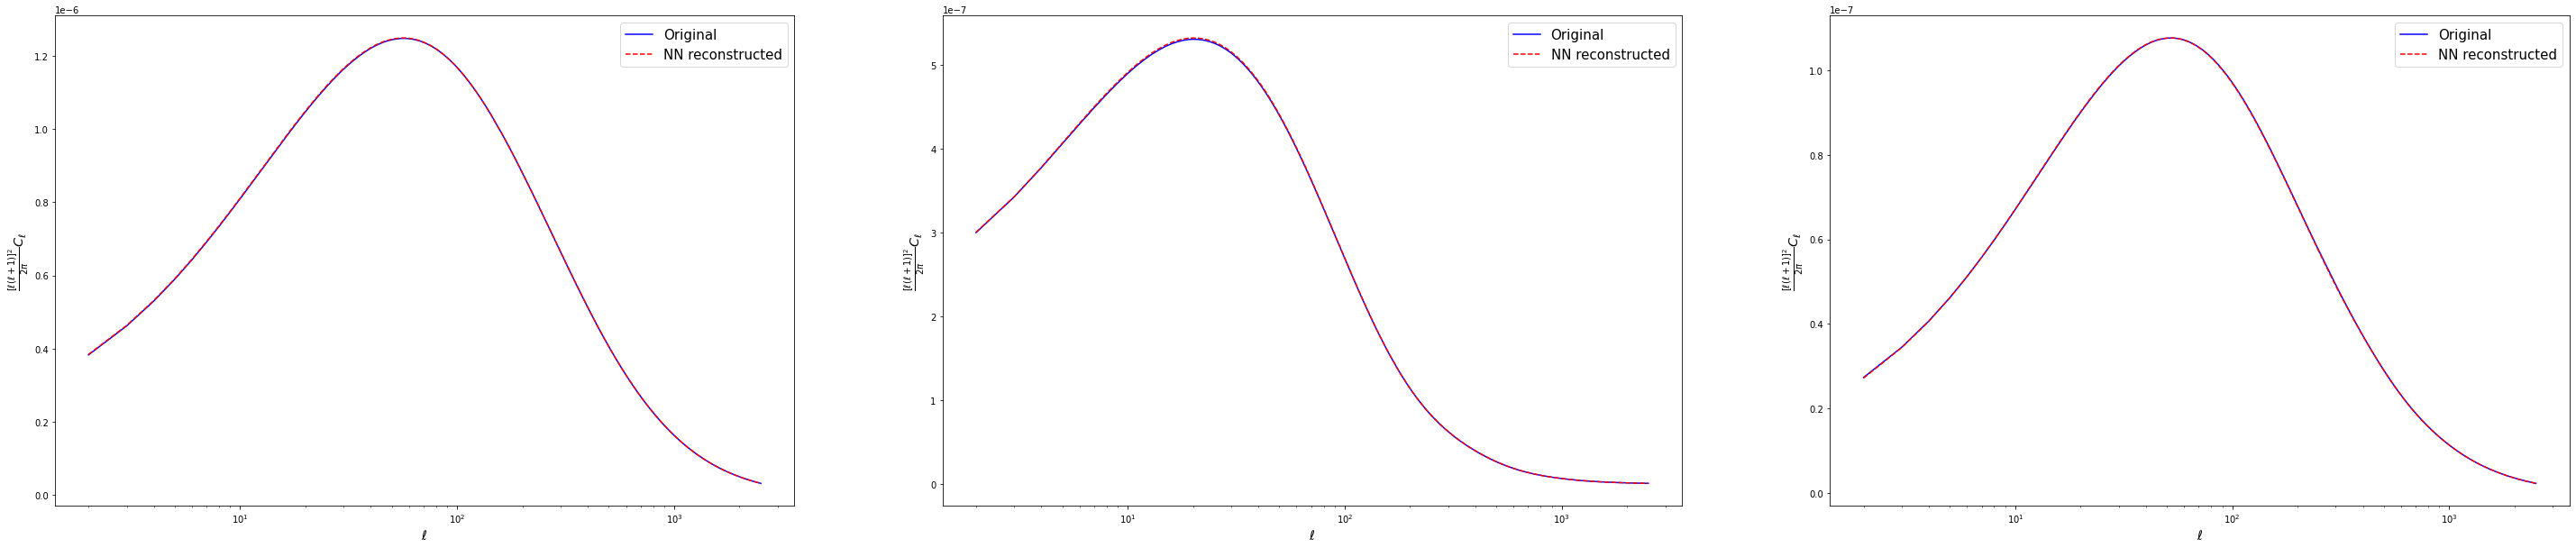

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(50,10))
for i in range(3):
    pred = predicted_testing_spectra[i]*ell_range*ell_range*(ell_range+1)*(ell_range+1)/(2.*np.pi)
    true = testing_spectra[i]*ell_range*ell_range*(ell_range+1)*(ell_range+1)/(2.*np.pi)
    ax[i].semilogx(ell_range, true, 'blue', label = 'Original')
    ax[i].semilogx(ell_range, pred, 'red', label = 'NN reconstructed', linestyle='--')
    ax[i].set_xlabel('$\ell$', fontsize='x-large')
    ax[i].set_ylabel('$\\frac{[\ell(\ell+1)]^2}{2 \pi} C_\ell$', fontsize='x-large')
    ax[i].legend(fontsize=15)
plt.savefig('examples_reconstruction_PP.pdf')

We want to plot accuracy in units of Simons Observatory (SO) noise curves. 
Start by loading SO noise curves from [the SO repository](https://github.com/simonsobs/so_noise_models) 

In [ ]:
!git clone https://github.com/simonsobs/so_noise_models

Cloning into 'so_noise_models'...
remote: Enumerating objects: 179, done.
remote: Counting objects: 100% (179/179), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 179 (delta 69), reused 147 (delta 47), pack-reused 0
Receiving objects: 100% (179/179), 7.96 MiB | 22.95 MiB/s, done.
Resolving deltas: 100% (69/69), done.


In [ ]:
# load noise models from the SO noise repo
noise_levels_load = np.loadtxt('./so_noise_models/LAT_lensing_noise/lensing_v3_1_0/nlkk_v3_1_0deproj0_SENS1_fsky0p4_it_lT30-3000_lP30-5000.dat')

In [ ]:
ells = noise_levels_load[:, 0]
SO_PP_MV_noise = noise_levels_load[:, 7][:2507]

In [ ]:
new_ells = ells[:2507] # 2509 is the final for our spectra, starting from 2
SO_PP_MV_noise /= (new_ells*(new_ells+1)/2)**2 # convert from kappa_kappa to phi_phi

In [ ]:
f_sky = 0.4
prefac = np.sqrt(2/(f_sky*(2*new_ells+1)))
denominator = prefac*(testing_spectra+SO_PP_MV_noise)  # use all of them
diff = np.abs((testing_spectra - predicted_testing_spectra)/(denominator))

# Compute percentiles
percentiles = np.zeros((4, diff.shape[1]))

percentiles[0] = np.percentile(diff, 68, axis = 0)
percentiles[1] = np.percentile(diff, 95, axis = 0)
percentiles[2] = np.percentile(diff, 99, axis = 0)
percentiles[3] = np.percentile(diff, 99.9, axis = 0)

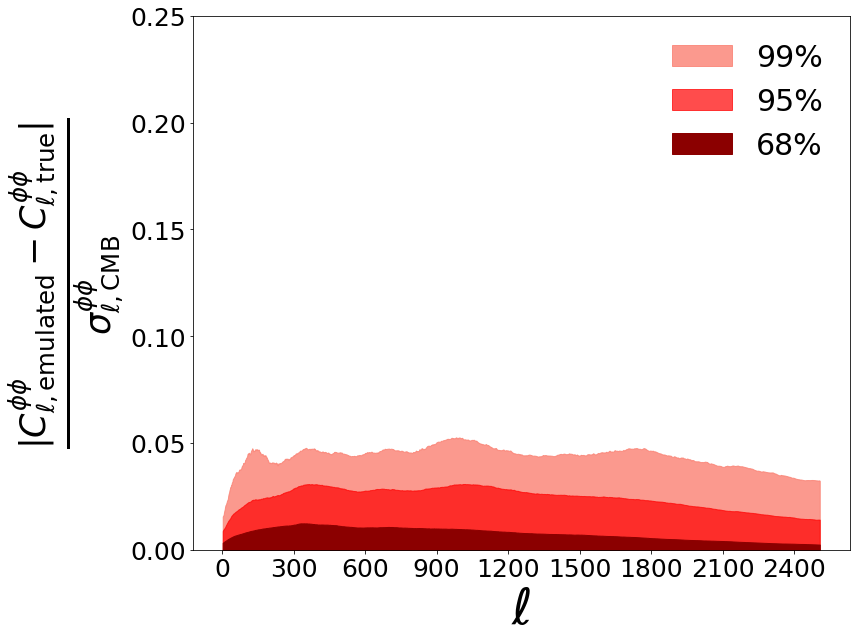

In [ ]:
plt.figure(figsize=(12, 9))
plt.fill_between(new_ells, 0, percentiles[2,:], color = 'salmon', label = '99%', alpha=0.8)
plt.fill_between(new_ells, 0, percentiles[1,:], color = 'red', label = '95%', alpha = 0.7)
plt.fill_between(new_ells, 0, percentiles[0,:], color = 'darkred', label = '68%', alpha = 1)

plt.ylim(0, 0.25)

plt.legend(frameon=False, fontsize=30, loc='upper right')
plt.ylabel(r'$\frac{| C_{\ell, \rm{emulated}}^{\phi \phi} - C_{\ell, \rm{true}}^{\phi \phi}|} {\sigma_{\ell, \rm{CMB}}^{\phi \phi}}$', fontsize=50)
plt.xlabel(r'$\ell$',  fontsize=50)

ax = plt.gca()
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.yaxis.set_major_locator(plt.MaxNLocator(5))

plt.setp(ax.get_xticklabels(), fontsize=25)
plt.setp(ax.get_yticklabels(), fontsize=25)
plt.tight_layout()
plt.savefig('./accuracy_emu_PP_wide.pdf')